## Imports

In [40]:
import sys
sys.path.insert(0, "../src")

import preprocessing as prep
import model
from main import *
from tqdm import tqdm
import torch
import torch.utils.data
import os
from torchvision.utils import make_grid
import torch.nn as nn
import torch.optim as optim
from timeit import default_timer as timer
import model
import preprocessing as prep
import argparse
from torch.utils.tensorboard import SummaryWriter
from pathlib import Path
import json


hparams = {
   # You can configure the following parameters.
   # Currently configured to load ...
   # Changing these parameter can force a new training
   "batch_size": 32,
   "rnn_layers" : 3,
   "shuffle" : True,
   "cnn_model": "resnet50",#values "lstm", "gru", "resnet50"
   "rnn_model": "gru",
   "improve_embedding": True,
   "improve_cnn": False,
   "image_size": 370,# between 256 and 640
   "crop_size": 320,# minimum 224, must be lower than "image_size"
   "caption_number" : 4, #number of captions to use in the dataset. between 1 and 5
   "cutoff": 2, # Minimum word frequency to not flag a word as unknwon
   "clip_grad": None,# set to 1.0 if NaN values appear during training
   "weight_decay": 0, # L2 Regularization
   "num_epochs": 100,
   "lr": 0.001,# learning rate
   "sgd_momentum": None,# 
   "break_training_loop_percentage": 10,
   "drop_out_prob" : 0,# only when "rnn_layers" > 1, otherwise set to 0
   "sampling_method": "",# either "beam_search", "sample_search" or "" for a greedy search
   "beam_width": 3,
   "training_report_frequency" : 5,
   "last_saved_model" : None,
   #Do not change the following parameters
   "use_pixel_normalization" : True,
   "compute_val_loss": True,
   "keep_best_val_loss": False,
   "keep_best_total_loss": True,
   "gold_eval_with_original": True,
   "device": "cuda:0",
   "root": "../data",
   "annotation_without_punctuation": False,
   "train": "train2017",
   "val": "val2017",
   "test": "test2017",
   "timestamp_prefix": "%d%b%Y_%H_%M_%S_%f",
   "debug": False,
   "print_prediction" : False,
   "save_eval_results" : False,
   "model_name": "_.pt",
   "use_glove": True,
   "use_padding_idx": True,
   "model_storage": "./model_storage",
   "glove_embedding": "glove.6B.300d.bin.word2vec",
   "save_pending_model" : False,
   "hidden_dim": 512,
   "embedding_dim" : 300,
   "use_tensorboard":False
}

#End - Do not change these!
HYPER_PARAMETER_CONFIG = "../hparams.json"
MODEL_STORAGE="../model_storage"
#hparams = prep.read_json_config(HYPER_PARAMETER_CONFIG)
ROOT="../data"
SEED = 1
PADDING_WORD="<MASK>"
hparams["root"]=ROOT
hparams["model_storage"]=MODEL_STORAGE
trainset_name = "train"
valset_name = "val"
testset_name = "test"
#End - Do not change these!

## Load Embeddings

In [41]:
import preprocessing as prep
torch.cuda.empty_cache()

device = hparams["device"]
if not torch.cuda.is_available():
    print("Warning, only CPU processing available!")
    device = "cpu"
else:
    print("CUDA GPU is available", "Number of machines:", torch.cuda.device_count())

#Makes results more reproducible
prep.set_seed_everywhere(SEED)

#Prepare the vectorizer, mapping words to indices and vice versa
cleaned_captions = prep.get_captions(hparams, trainset_name)
cutoff_for_unknown_words = hparams["cutoff"]
vectorizer = model.CaptionVectorizer.from_dataframe(cleaned_captions, cutoff_for_unknown_words)


#Creates embedding model
padding_idx = None
if (hparams["use_padding_idx"]):
    padding_idx = vectorizer.get_vocab()._token_to_idx[PADDING_WORD]
embedding = util.create_embedding(hparams, vectorizer, padding_idx)

CUDA GPU is available Number of machines: 1
loading annotations into memory...
Done (t=0.34s)
creating index...
index created!
Loading glove vectors...
GloVe embedding size: 300


##  TODO add the name of the best model file for training

## Training and testing. You can skip this cell, if you just want to see predictions.

In [ ]:
#Creates Data loaders
train_loader = util.CocoDatasetWrapper.create_dataloader(hparams, vectorizer, trainset_name)
#the pictures for the training set and the test set shares the same directory, "train2017"
test_loader = util.CocoDatasetWrapper.create_dataloader(hparams, vectorizer, testset_name, "train2017")
val_loader = util.CocoDatasetWrapper.create_dataloader(hparams, vectorizer, valset_name)

#Creates the network
network = model.RNNModel(hparams["hidden_dim"], pretrained_embeddings=embedding,
                         cnn_model=hparams["cnn_model"], rnn_layers=hparams["rnn_layers"],
                         rnn_model=hparams["rnn_model"], drop_out_prob=hparams["drop_out_prob"],
                         improve_cnn=hparams["improve_cnn"]).to(device)

#Either load previous state or starts a training
start_training = init_model(hparams, network, False)
break_training_loop_idx, break_val_loop_idx, break_test_loop_idx = get_stop_loop_indices(hparams, train_loader,
                                                                                         val_loader, test_loader)

#Training
if start_training:
    loss_function = nn.NLLLoss().to(device)
    train(hparams, loss_function, network, train_loader, device, break_training_loop_idx, val_loader)

# Evaluation Part    
#model.BleuScorer.perform_whole_evaluation(hparams, train_loader, network, break_training_loop_idx, "train")
bleu.BleuScorer.perform_whole_evaluation(hparams, test_loader, network, break_test_loop_idx, "test")


## Configure data for predictions

In [8]:
from torchvision import transforms
import torchvision.datasets as dset
import matplotlib.pyplot as plt
%matplotlib inline

name="val"
train_file = hparams[name]
image_dir = os.path.join(hparams['root'], train_file)
caption_file_path = prep.get_correct_annotation_file(hparams, name)
device = hparams["device"]
if not torch.cuda.is_available():
    print("Warning, only CPU processing available!")
    device = "cpu"
else:
    print("CUDA GPU is available", "Number of machines:", torch.cuda.device_count())


#START PARAMETERS to adapt if needed
model_to_load="lp10_img370_cs320_resnet50_gru_l3_hdim512_emb300_lr0.001_wd0_epo100_bat32_do0_cut2_can5_with_norm_ie_s.pt"
hidden_dim=512
cnn_model="resnet50"
rnn_layers=3
rnn_model="gru"
drop_out_prob=0
num_image_to_show=10
#END PARAMETERS to adapt if needed




CUDA GPU is available Number of machines: 1


## Predictions...

Using resnet50...

Load temporary model:  ../model_storage\lp10_img370_cs320_resnet50_gru_l3_hdim512_emb300_lr0.001_wd0_epo100_bat32_do0_cut2_can5_with_norm_ie_s.pt
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Prediction: a dog sitting in a living room next to a stove


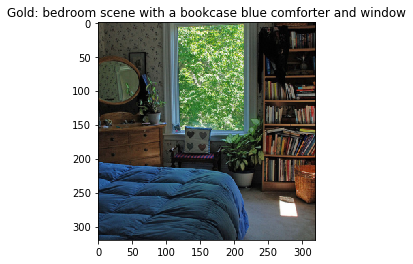

Prediction: a traffic light sitting on the side of a road


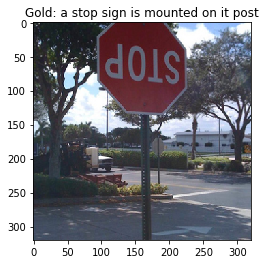

Prediction: a meatball sandwich covered in gravy in a bowl


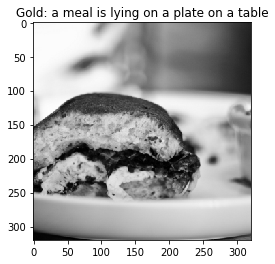

Prediction: a group of people wearing hats and posing with their hands together


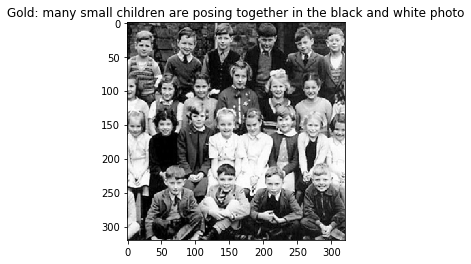

Prediction: a person is standing in the snow on a board


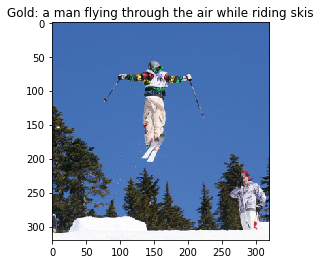

Prediction: a cat sitting in a toilet drinking out of it


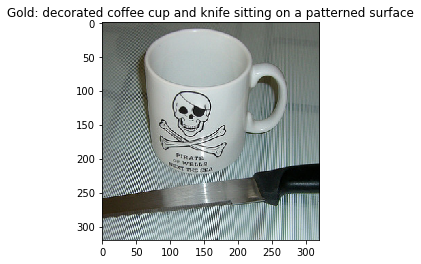

Prediction: a man standing in front of a hello kitty tv with a cat sleeping on top of it


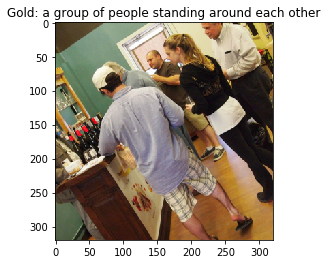

Prediction: a bowl filled with fruit of different kinds


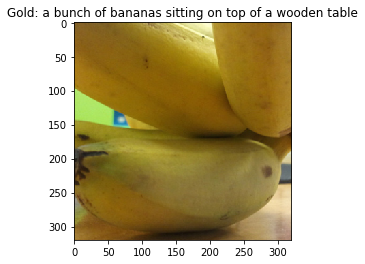

Prediction: a group of people standing around a table eating food


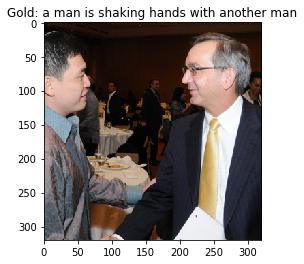

Prediction: a train is going down the tracks in the city


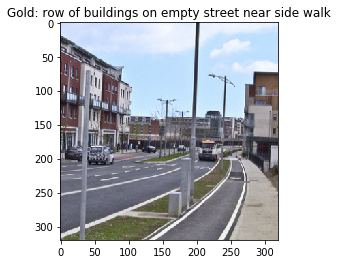

In [9]:
%matplotlib inline
network = model.RNNModel(hidden_dim, pretrained_embeddings=embedding,
                             cnn_model=cnn_model, rnn_layers=rnn_layers,
                             rnn_model=rnn_model, drop_out_prob=drop_out_prob,
                             improve_cnn=False).to(device)
last_model = os.path.join(hparams["model_storage"], model_to_load)
if os.path.isfile(last_model):
    print("\nLoad temporary model: ", last_model)
    network.load_state_dict(torch.load(last_model))
else:
    print("\nWARNING!!!!!! Temporary model cannot be loaded", last_model)

transform_without_norm = transforms.Compose([transforms.Resize(hparams["image_size"]),
                                     transforms.CenterCrop(hparams["crop_size"]),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
                                    ])
coco_val_t = dset.CocoDetection(root=image_dir,
                                    annFile=caption_file_path,
                                    transform=transform_without_norm
                                    )
#val_loader_no_transform = torch.utils.data.DataLoader(coco_val_t, batch_size=hparams["batch_size"])

transform = transforms.Compose([transforms.Resize(hparams["image_size"]),
                                     transforms.CenterCrop(hparams["crop_size"]),
                                     transforms.ToTensor()
                                    ])
coco_val = dset.CocoDetection(root=image_dir,
                                    annFile=caption_file_path,
                                    transform=transform
                                    )
#val_loader = torch.utils.data.DataLoader(coco_val, batch_size=hparams["batch_size"])

iter_val= iter(coco_val)
iter_val_t= iter(coco_val_t)



for idx in range(num_image_to_show):
    original_img, _ = next(iter_val)
    transformed_img, annotations = next(iter(iter_val_t))
    starting_token = vectorizer.create_starting_sequence().unsqueeze(dim=0).unsqueeze(dim=0).to(device)
    model_input = (transformed_img.unsqueeze(dim=0).to(device),starting_token)
    predicted_label = network.predict_greedy(model_input)
    prediction = vectorizer.decode(predicted_label[0][0])
    print("Prediction:", prediction)
    plt.imshow(original_img.permute(1,2,0))
    plt.title("Gold: "+annotations[0]["caption"])
    plt.show()

In [47]:
hparams

{'batch_size': 32,
 'rnn_layers': 3,
 'shuffle': True,
 'cnn_model': 'resnet50',
 'rnn_model': 'gru',
 'improve_embedding': True,
 'improve_cnn': False,
 'image_size': 370,
 'crop_size': 320,
 'caption_number': 5,
 'cutoff': 2,
 'clip_grad': None,
 'weight_decay': 1e-05,
 'num_epochs': 100,
 'lr': 0.001,
 'sgd_momentum': None,
 'break_training_loop_percentage': 10,
 'drop_out_prob': 0,
 'sampling_method': '',
 'beam_width': 3,
 'training_report_frequency': 5,
 'last_saved_model': None,
 'use_pixel_normalization': True,
 'compute_val_loss': True,
 'keep_best_val_loss': False,
 'keep_best_total_loss': True,
 'gold_eval_with_original': True,
 'device': 'cuda:0',
 'root': '../data',
 'annotation_without_punctuation': False,
 'train': 'train2017',
 'val': 'val2017',
 'test': 'test2017',
 'timestamp_prefix': '%d%b%Y_%H_%M_%S_%f',
 'debug': False,
 'print_prediction': False,
 'save_eval_results': False,
 'model_name': '_.pt',
 'use_glove': True,
 'use_padding_idx': True,
 'model_storage': '..